In [903]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance
import statsmodels.api as sm
import shap
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
pd.set_option('display.max_rows', None)

In [904]:
data = pd.read_csv('Real_State_Bogota.csv')
data.head()

,longitude,latitude,stratum,bathrooms,constructed_area,house_age,bedrooms,parking,administration,floor,rent_price,facilities
0,-74.048398,4.700991,5.0,2.0,97.0,12.0,2.0,2.0,0.0,0.0,4500000.0,[]
1,-74.055693,4.687506,6.0,1.0,42.0,12.0,1.0,1.0,0.0,5.0,2800000.0,"['Ascensor', 'Balcón', 'Caldera', 'Calentador'..."
2,-74.052512,4.675927,6.0,4.0,116.0,23.0,4.0,2.0,0.0,7.0,5500000.0,"['Baño Auxiliar', 'Calentador', 'Chimenea', 'C..."
3,-74.049210,4.672860,5.0,3.0,138.0,23.0,3.0,2.0,0.0,4.0,8000000.0,"['Acceso Pavimentado', 'Amoblado', 'Ascensor',..."
4,-74.050727,4.700429,5.0,2.0,78.0,23.0,3.0,1.0,0.0,3.0,4000000.0,"['Acceso Pavimentado', 'Ascensor', 'Baño Indep..."


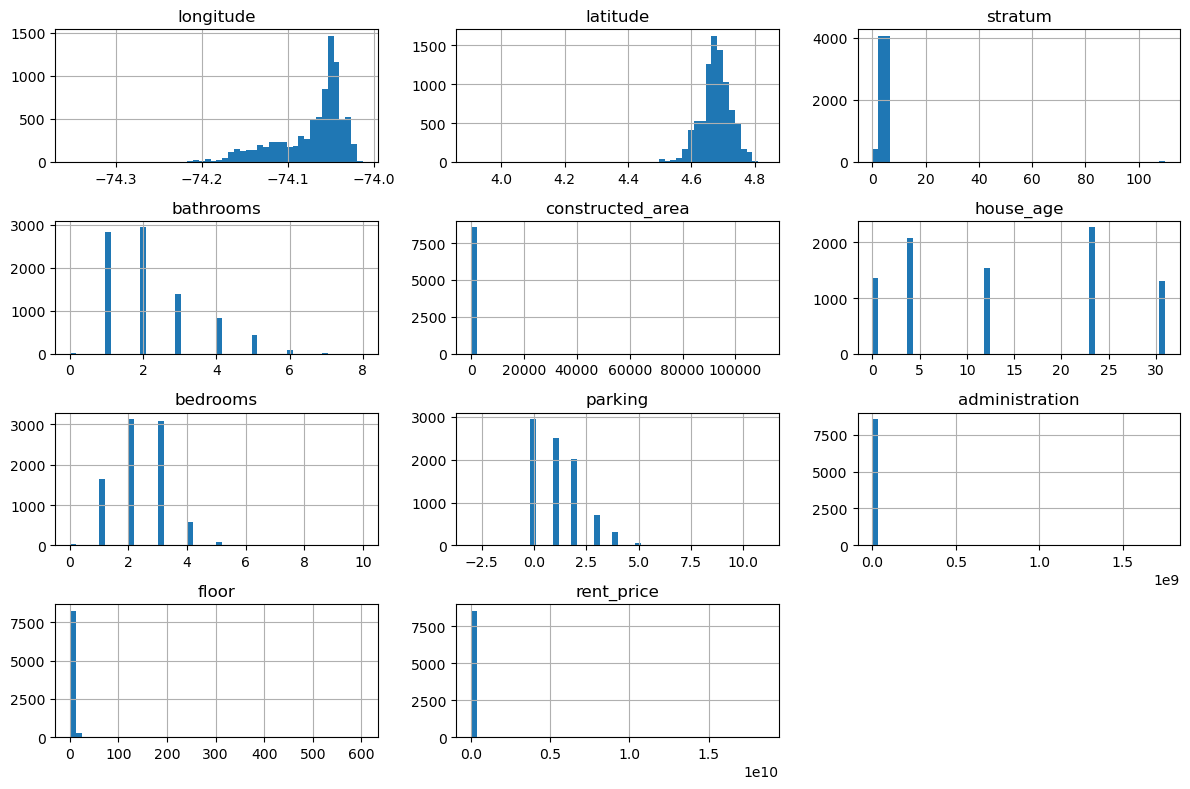

In [905]:
data.hist(bins=50, figsize=(12,8))
plt.tight_layout()
plt.show()

In [906]:
data = data.dropna()

In [907]:
#Las variables longitude y latitude son fundamentales que se encuentren dentro del area que corresponde a Bogota, el siguiente codigo descarta apartamentos fuera del area de Bogota
data = data[(data['latitude']>=4.45)&(data['latitude']<=4.83)]
data = data[(data['longitude']>=-74.25)&(data['longitude']<=-73.8)]

In [908]:
#La variable stratum tiene claramente outliers ya que en Bogota el estrato maximo es el 6. y los parqueaderos no pueden ser menores a 0
data.loc[data['stratum'] > 6,'stratum'] = 6
data.loc[data['parking'] < 0,'parking'] = 0

In [909]:
#Con la intencion de elimminar solo valores outliers de las restantes variables se va a multiplicar el IQR por 3
out_features = ['bathrooms', 'constructed_area', 'bedrooms','parking', 'administration', 'rent_price', 'floor']
for i in out_features:
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3-Q1
    upper_bond = Q3 + 3*IQR
    data.loc[data[i] > upper_bond, i] = upper_bond

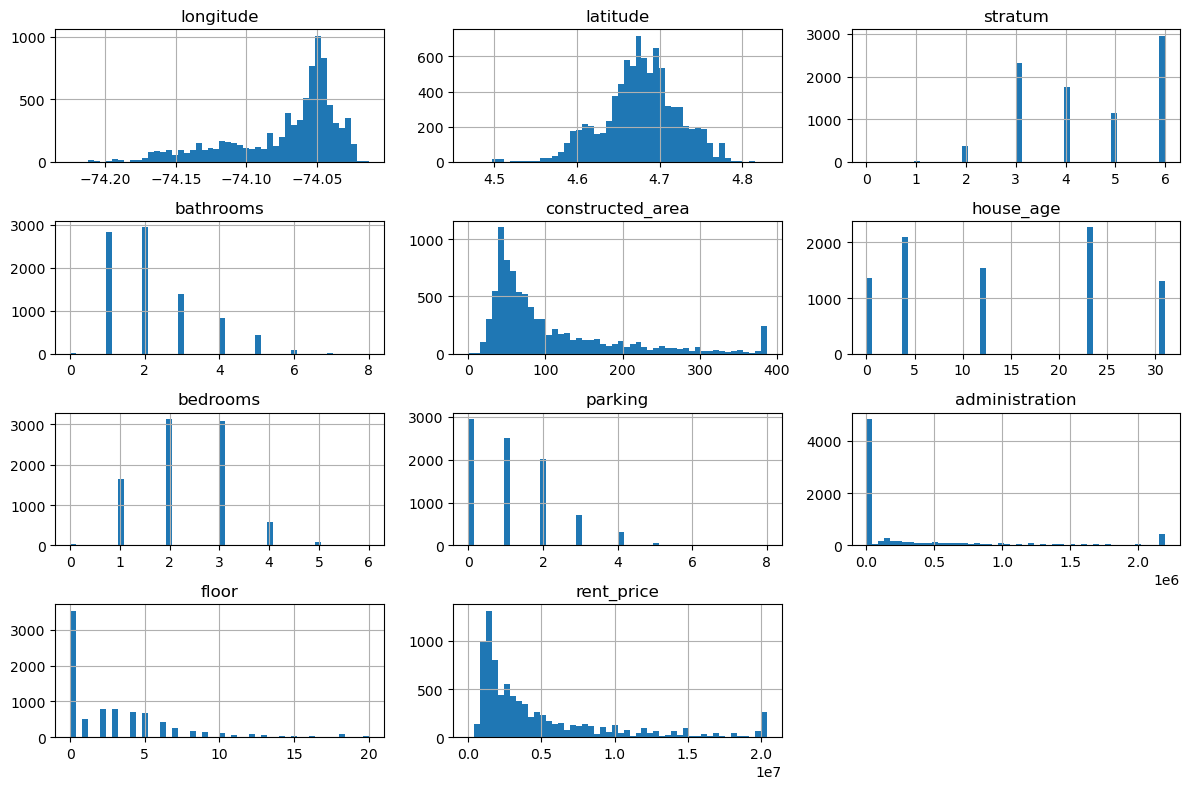

In [910]:
data.hist(bins=50, figsize=(12,8))
plt.tight_layout()
plt.show()

In [911]:
#Transformacion de variable facilities que esta en formato string a formato array
data['facilities'] = data['facilities'].apply(ast.literal_eval)

In [912]:
#Se contabilizan las comodidades mas comunes en data set 
facilities = {}
for i in data['facilities']:
    for j in i:
        facilities[j] = facilities.get(j, 0) + 1

n_rows = data.shape[0]
#Ahora se identificaran las comodidades menos comunes para descartarlas de los datos
low_importance_facilities = []
for i in facilities:
    if (facilities[i]/n_rows) <= 0.1:
        low_importance_facilities.append(i) 
print(low_importance_facilities)

['Caldera', 'Loft', 'Patio', 'Acceso Pavimentado', 'Baño Independiente', 'Alarma', 'Cerca de Zona Urbana', 'Cochera', 'Jardín', 'Cancha de Squash', 'Duplex', 'Oficina de negocios', 'Sala de internet', 'Baño compartido', 'Baños comunales', 'Baños Públicos', 'Cocina Equipada', 'Sauna / Turco / Jacuzzi', 'Seguridad', 'Zona de BBQ', 'Vivienda Multifamiliar', 'Alcantarillado', 'Comedor auxiliar', 'Aire Acondicionado', 'Sensor de movimiento', 'Garaje / Parqueadero(s)', 'Garaje Cubierto', 'Piscina', 'Portería / Vigilancia', 'Servicios independientes', 'Ubicada en edificio', 'Salón de Juegos', 'Asador', 'Bombas de gasolina', 'Despensa', 'Con casa club', 'En condominio', 'Bahía exterior de parqueo', 'Cancha de Tennis', 'Escalera de Emergencia', 'Vivienda Bifamiliar', 'Cuarto de Escoltas', 'Jaula de Golf', 'En Edificio', 'En zona Comercial', 'Piso de alta resistencia', 'Árboles frutales', 'Cableado de Red', 'Puerta de seguridad', 'En centro Comercial', 'Servicio de Internet', 'PentHouse', 'Zona 

In [913]:
# removiendo las keys con baja inportanca del dictionario facilities
for key_to_remove in low_importance_facilities:
    if key_to_remove in facilities: 
        del facilities[key_to_remove]

len(facilities)

54

In [914]:
#Eliminación de las variables con baja presencia de la variables facilities para crear las nuevas columnas en el dataset
data['facilities'] = data['facilities'].apply(lambda lista: [item for item in lista if item not in low_importance_facilities ])

In [915]:
# Se crearon y añadieron todas la columnas de comodidades encontradas al dataset
new_cols = pd.DataFrame(0, index=data.index, columns=list(facilities.keys()))
data = pd.concat([data, new_cols], axis=1)
data.shape

(8561, 66)

In [916]:
#Se asigna el valor 1 a las columnas que estan en la lista de facilities
for idx, i in enumerate(data['facilities']):
    for j in i:
        data.at[idx, j] = 1
data = data.drop(columns=['facilities'])

In [917]:
#Identificacion de variables con una correlacion mayor al 80%
df_facilities = data[facilities.keys()]
corr_facilities = df_facilities.corr().abs()
mask = np.triu(np.ones(corr_facilities.shape), k=1).astype(bool)
corr_features = corr_facilities.where(mask)
high_corr = [column for column in corr_features.columns if any(corr_features[column].abs()>0.8)]
print(high_corr)

['Ventilación Natural']


In [918]:
#Elimination of high correlated features
data = data.drop(columns=high_corr)

Con el objetivo de reducir mas el tamaño del dataset se va utilizar el metodo de Información Mutua (MI) que mide cuánta informacion comparte una variable X con un variable Y, es decir que tanto saber el valor X reduce la incertidumbre sobre Y

In [919]:
data = data.dropna(how='any')

In [920]:
X = data.drop(columns=['rent_price'])
y = data['rent_price']
mi_scores = mutual_info_regression(X, y)
mi_series = pd.Series(mi_scores, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)

<Axes: >

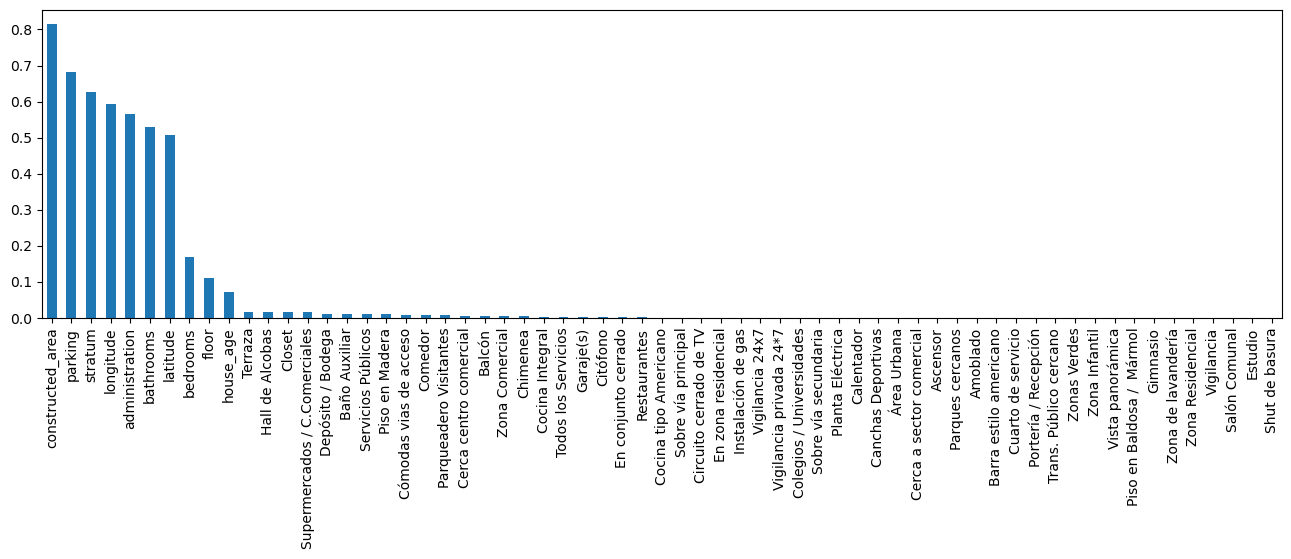

In [921]:
#Grafico para visualizar las variables mas relevantes o con mas poder predictivo
mi_series.plot(kind='bar', figsize=(16, 4))

Como se puede ver en la grafica casi todas las variables correspodientes a comodidades tiene casi un poder predictivo de 0. Por lo tanto solo se utilizaran variables que este por encima de un umbral de 0.05 (5%).

In [922]:
low_ml = mi_series[mi_series<0.05].index
data = data.drop(columns=low_ml)

In [923]:
data.head()

,longitude,latitude,stratum,bathrooms,constructed_area,house_age,bedrooms,parking,administration,floor,rent_price
0,-74.048398,4.700991,5.0,2.0,97.0,12.0,2.0,2.0,0.0,0.0,4500000.0
1,-74.055693,4.687506,6.0,1.0,42.0,12.0,1.0,1.0,0.0,5.0,2800000.0
2,-74.052512,4.675927,6.0,4.0,116.0,23.0,4.0,2.0,0.0,7.0,5500000.0
3,-74.049210,4.672860,5.0,3.0,138.0,23.0,3.0,2.0,0.0,4.0,8000000.0
4,-74.050727,4.700429,5.0,2.0,78.0,23.0,3.0,1.0,0.0,3.0,4000000.0


In [924]:
X = data.drop(columns=['rent_price'])
y = data['rent_price']

In [925]:
continuos_features = ['longitude', 'latitude', 'constructed_area', 'house_age', 'administration', 'floor','stratum', 'bathrooms', 'bedrooms', 'parking']
discrete_features = [feature for feature in X.columns if feature not in continuos_features]

In [926]:
preprocessor = ColumnTransformer(transformers=[
    ('cont', StandardScaler(), continuos_features)
])

In [927]:
models = {
    'LinearRegression': LinearRegression(),
    'LassoCV': LassoCV(cv=5),
    'RandomForest':RandomForestRegressor(random_state=42),
    'XGBoost':  XGBRegressor(n_estimator=100, random_state = 42, verbosity=0)
}

In [928]:
def models_fit(models, X, y, preprocessor):
    results = []
    
    for name, model_instance in models.items():
        pipe = Pipeline(steps = [
            ('preprocessor', preprocessor),
            ('regressor', model_instance)
        ])
        
        scores  = cross_val_score(pipe, X, y,  cv=5, scoring='neg_root_mean_squared_error')
        results.append({
            'Model': name,
            'RMSE Mean': -np.mean(scores),
            'RSME Std': np.std(scores)
        })
    results_df = pd.DataFrame(results).sort_values(by = 'RMSE Mean')    
    return results_df

model_results = models_fit(models, X, y, preprocessor)
print(model_results)

KeyboardInterrupt: 

In [ ]:
param_grid_rf = {
    'regressor__n_estimators': [200, 300, 400],
    'regressor__max_depth': [None, 20, 30],
    'regressor__min_samples_split': [2, 5, 7]
}

grid_search_rf = GridSearchCV(
    Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ]),
    param_grid_rf, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_rf.fit(X, y)
print(f"Best RMSE: {-grid_search_rf.best_score_:.2f}")
print("Best params:", grid_search_rf.best_params_)

Best RMSE: 1201403.77
Best params: {'regressor__max_depth': None, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 400}


In [ ]:
param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.07],
    'regressor__max_depth':[5, 8, 10],
    'regressor__subsample':[0.8, 1],
    'regressor__colsample_bytree': [0.8, 1],
    'regressor__reg_lambda': [1,2]
}

grid_search_xgb = GridSearchCV(
    Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(n_estimators =100, random_state=42, verbosity=0))
    ]),
    param_grid_xgb, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1)

grid_search_xgb.fit(X, y)
best_index = grid_search_xgb.best_index_
std_rmse = grid_search_xgb.cv_results_['std_test_score'][best_index]

print(f"Best RMSE: {-grid_search_xgb.best_score_:.2f}")
print("Best params:", grid_search_xgb.best_params_)
print("Best score (std_RMSE):", std_rmse)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best RMSE: 1157712.00
Best params: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 8, 'regressor__n_estimators': 300, 'regressor__reg_lambda': 2, 'regressor__subsample': 0.8}
Best score (std_RMSE): 46418.26354998755


Hasta el momento el modelo XGBoost es el mejor, el uso de grid_search para permutar los hiperparametros mejoro bastante el rendimiento del modelo.  
Con el mejor modelo identificado se puede realizar la evaluacion del modelo con datos de entrenamiento y de testeo, para evaluar el poder predictivo del modelo.

In [ ]:
#Ahora es momento de medir el poder predictivo del modelo obtenido evaluando dos metricas, la raiz del error medio cuadrado y el corf de determinación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = grid_search_xgb.best_estimator_

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE test: {rmse:.2f}')
print(f'R2 test: {r2:.2f}')

RMSE test: 1163329.22
R2 test: 0.91


#### <font color=#A0A0A0> **🤖 Results and Evaluation**</font>

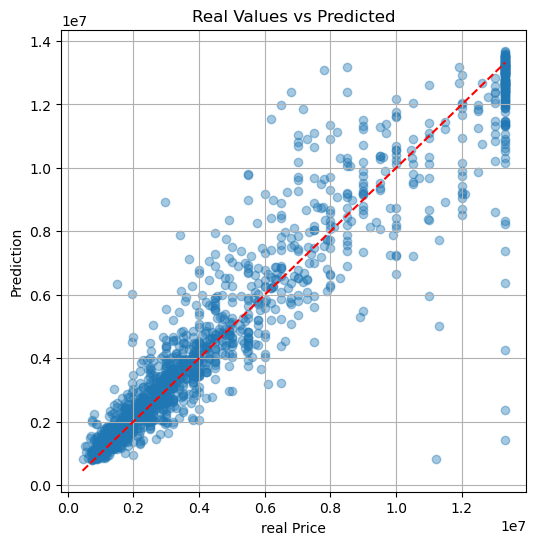

In [ ]:
#Graficación de la correlacion entre el precio real y le predicho
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("real Price")
plt.ylabel("Prediction")
plt.title("Real Values vs Predicted")
plt.grid(True)
plt.show()

Hay una clara relación lineal entre los valores reales y predichos. Algo que se pupede destacar de la grafica es que a medida que incrementa el precio del apartamento es mas dificil para el modelo redecir el precio por lo tanto la grafica se torna mas dispersa. Graficar las distribucion de errores es otra forma de visualizar que tan bien el modelo predice los precios.

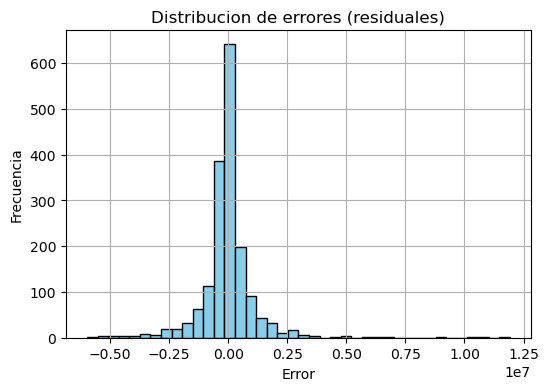

In [ ]:
# Grafica de distribucion de los residuales

residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, color='skyblue', edgecolor='black')
plt.title('Distribucion de errores (residuales)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Como se pudo observar en la grafica anterior el modelo tiene buen poder predicto como indica la distribucion de errores, la mayoria de estos se agrupan alrededor de cero con una desviacion de alrededor de 900.000

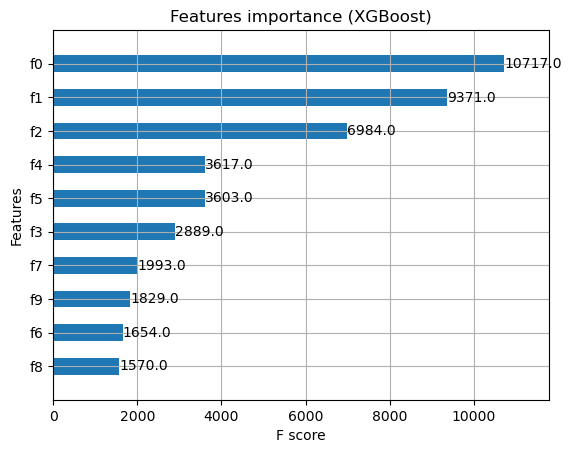

In [ ]:
#El modelo xgboost tiene la capacidad de graficar los features mas importantes para el modelo. 
# Esto es util para descartar features que no aporten mucho al modelo y en cambio generen ruido.
xgb_model = best_model.named_steps['regressor']
plot_importance(xgb_model, max_num_features=12, height=0.5)
plt.title('Features importance (XGBoost)')
plt.show()

In [ ]:
index_labels = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']
features_importance = pd.DataFrame(continuos_features, index=index_labels, columns=['feature'])
features_importance

,feature
f0,longitude
f1,latitude
f2,constructed_area
f3,house_age
f4,administration
f5,floor
f6,stratum
f7,bathrooms
f8,bedrooms
f9,parking


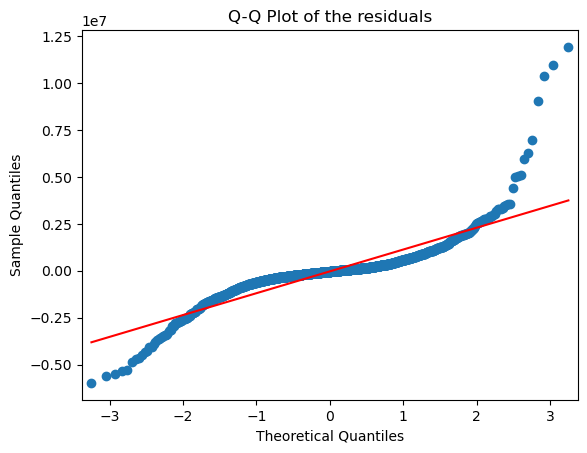

In [ ]:
#El grafico Q.Q es bueno para mostrar si los errores del modelo siguen una distribucion normal
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of the residuals')
plt.show()

Cuando se utilizan un modelo lineal es importante que el modelo siga una distribucion normal. Pero no es el caso de XGBoost porque este modelo puede manejar relacion no lineales. Sin embargo vale la pena probrar algun cambio en el modelo vigilando algunos outliers y features sesgados para mejorar el rendimiento.